<a href="https://colab.research.google.com/github/AbdullahMakhdoom/Customer_Segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [1]:
!pip install xlrd
!pip install --upgrade plotly
import numpy as np
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
from scipy import stats


     |████████████████████████████████| 13.2MB 4.1MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
!unzip archive.zip


Archive:  archive.zip
  inflating: Online Retail.xlsx      


### Loading Dateset

In [3]:
data = pd.read_excel("Online Retail.xlsx")

### Analysing Data

In [4]:
print(data.shape)

(541909, 9)


In [5]:
data.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
data.tail()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,NaN,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,NaN,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,NaN,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,NaN,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,NaN,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   lower        1816 non-null    object        
 3   Description  540455 non-null  object        
 4   Quantity     541909 non-null  int64         
 5   InvoiceDate  541909 non-null  datetime64[ns]
 6   UnitPrice    541909 non-null  float64       
 7   CustomerID   406829 non-null  float64       
 8   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


#### Removing "lower" Column

In [8]:
del data["lower"]

#### Removing Rows with Missing CustomerID

In [9]:
data = data[pd.notnull(data['CustomerID'])]

In [10]:
print(data.shape)

(406829, 8)


#### Removing Duplicates

In [11]:
filtered_data  = data.drop_duplicates()

In [12]:
print(filtered_data.shape)

(401604, 8)


#### Data Insights

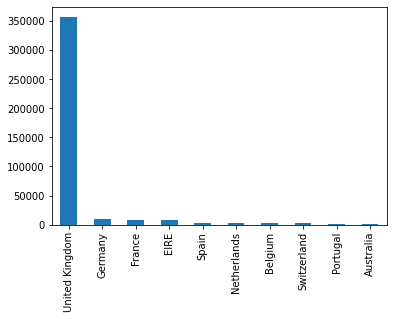

In [13]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')


Due to the overwhleming porportion of UK customers present in the dataset, the focus of the rest of the analysis is kept to UK's online retailers.

In [14]:
uk_data = data[data.Country == 'United Kingdom']

In [15]:
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [16]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


Filtering out rows with Negative Quantity Value

In [17]:
uk_data = uk_data[(uk_data['Quantity']>0)]

In [18]:
print(uk_data.shape)

(354345, 8)


Filtering only those Columns which are required for RFM Analysis.

In [19]:
uk_data = uk_data[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]


In [20]:
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']


In [25]:
uk_data['InvoiceDate'].min(), uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [26]:
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [27]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


### RFM Analysis

RFM analysis is a data-driven customer behavior segmentation technique where RFM stands for :-

- Recency : When their last purchase was.

- Frequency : How often they've purchased in the past.

- Monetary : How much have they spent.


In [28]:
# PRESENT constant for calculating Recency
# (PRESENT time - (Latest Purchasal time of Customer))
PRESENT = uk_data['InvoiceDate'].max() + dt.timedelta(days = 1)
print(PRESENT)

2011-12-10 12:49:00


In [30]:
# Grouping customers by their 'CustomerID'
rfm = uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days, # Last purchase of customer (in number of days) (Recency)
                                         'InvoiceNo': lambda num: len(num), # for getting frequency of purchasal (Frequency)
                                         'TotalPrice': lambda price: price.sum()}) # for total spending of customer (Monetary)

In [31]:
rfm.columns


Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [32]:
# Change the names of the columns
rfm.columns=['recency','frequency','monetary'] 

In [33]:
rfm['recency'] = rfm['recency'].astype(int)

In [34]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,2,103,4196.01
12748.0,1,4596,33719.73
12749.0,4,199,4090.88
12820.0,3,59,942.34


In [35]:
# qcut divides the columns into 4 equally sized bins
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [36]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,326,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,1,4596,33719.73,1,1,1
12749.0,4,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


### RFM Result Interpretation

In [37]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()


,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,1,4596,33719.73,1,1,1,111
12749.0,4,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


In [38]:
# Filter out Top/Best cusotmers
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18102.0,1,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
17511.0,3,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111


### Manage Skewness and Scaling

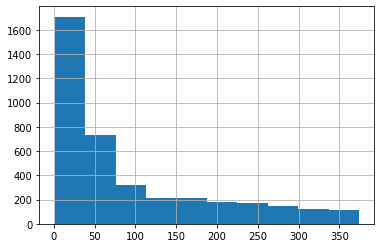

In [39]:
rfm['recency'].hist()

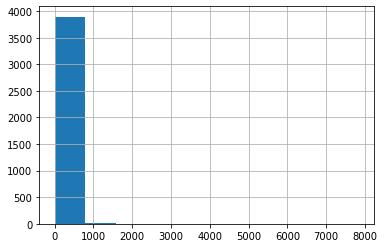

In [40]:
rfm['frequency'].hist()

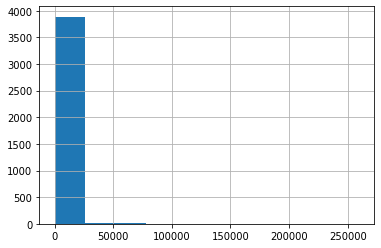

In [41]:
rfm['monetary'].hist()

In [42]:
rfm = rfm[rfm['recency'] > 0]

To make the data more normal (i.e: bell-shaped), we can apply box-cox transformation. https://www.statisticshowto.com/box-cox-transformation/

In [43]:
rfm_fix = pd.DataFrame()
rfm_fix["Recency"] = stats.boxcox(rfm['recency'])[0]
rfm_fix["Frequency"] = stats.boxcox(rfm['frequency'])[0]
rfm_fix["Monetary"] = pd.Series(np.cbrt(rfm['monetary'])).values

In [44]:
rfm_fix.tail()

,Recency,Frequency,Monetary
3916,9.641797,2.457480,5.652483
3917,8.524064,2.055787,4.323541
3918,2.513198,2.665931,5.625753
3919,1.570965,8.024068,12.795376
3920,5.342012,4.795920,12.247810


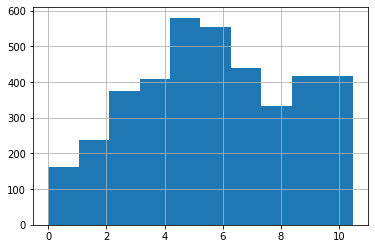

In [45]:
rfm_fix['Recency'].hist()

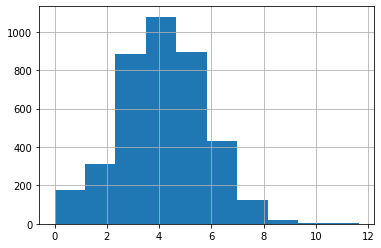

In [46]:
rfm_fix['Frequency'].hist()

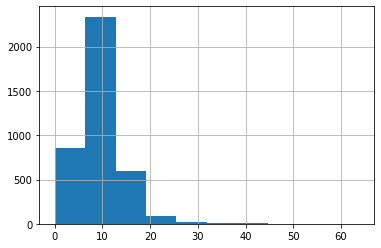

In [47]:
rfm_fix['Monetary'].hist()

#### Standarize the RFM

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(rfm_fix)
rfm_normalized = scaler.transform(rfm_fix)


In [49]:
print(rfm_normalized.mean(axis = 0).round(2))

[ 0. -0.  0.]


In [50]:
print(rfm_normalized.std(axis = 0).round(2))

[1. 1. 1.]


In [51]:
rfm_normalized

array([[ 1.62945131, -2.52020154,  6.9353007 ],
       [-1.83757825,  0.71274559,  1.35574519],
       [-2.11126839,  4.06398851,  4.76866416],
       ...,
       [-1.1784943 , -0.89128115, -0.86010588],
       [-1.52820437,  2.38261499,  0.65243124],
       [-0.12857977,  0.41017151,  0.53691423]])

### Modelling

In [52]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k ,random_state=42)
  kmeans.fit(rfm_normalized)
  sse[k] = kmeans.inertia_


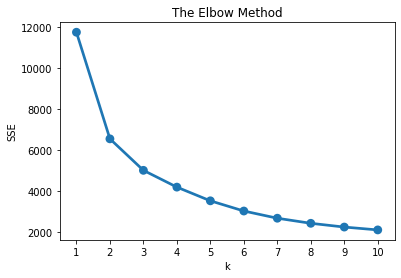

In [53]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

According to Elbow Method, we choose the value of k just right where the slope starts becoming linear. Since from k=3 onwards, slope starts to become almost linear, so we select the number of clusters to be k=3.

In [54]:
model = KMeans(n_clusters = 3, random_state=42)
model.fit(rfm_normalized)
model.labels_

array([2, 2, 2, ..., 1, 2, 1], dtype=int32)

### Interpreting the Segmented Customers

In [55]:
rfm["Cluster"] = model.labels_
rfm.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency' : 'mean',
    'monetary' : ['mean' , 'count']}).round(2)

recency frequency monetary      
           mean      mean     mean count
Cluster                                 
0        181.57     19.44   371.46  1519
1         42.00     68.38  1014.58  1732
2         19.30    308.04  7443.10   670

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


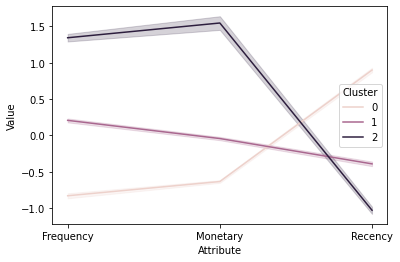

In [56]:
# Create the dataframe
df_normalized = pd.DataFrame(rfm_normalized, columns=
                             ['Recency', 'Frequency', 'Monetary'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_

# Melt the data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=
                      [ 'Frequency', 'Monetary', 'Recency'],
                      var_name='Attribute',
                      value_name = 'Value')
df_nor_melt.head()

# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt )

### Interpretation

**Cluster-0**  bought products least frequently, spend less money but they bought products just recently. Therefore, this cluster would be ***new customers***.

**Cluster-1** bought products more frequently, spend more money, and they bought goods recently .Therefore, this cluster could indicate the ***loyal/regular customers***.

**Cluster-2** have high shopping frequency, spent most money but they bought products long time ago. Therefore these could be ***churned customers***.
 . 

In [69]:
import plotly.graph_objects as go

PLOT = go.Figure()

CUSTOMER = ['New', 'Regular', 'Churned']
COLOR = ['orange', 'green', 'red']

for C in list(df_normalized.Cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df_normalized[df_normalized.Cluster == C]['Frequency'],
                                y = df_normalized[df_normalized.Cluster == C]['Monetary'],
                                z = df_normalized[df_normalized.Cluster == C]['Recency'],
                                mode = 'markers', marker_color = COLOR[C], 
                                marker_size = 5, marker_line_width = 1,
                                name = CUSTOMER[C]) )


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Moentary', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

PLOT.show()

### Conclusion
RFM technique is a proven marketing model that helps retailers and e-commerce businesses maximize the return on their marketing investments.
The above-generated RFM customer segments can be easily used to identify high Region of Interest segments and engage them with personalized offers.